In [21]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [22]:
df = pd.read_csv("Customer Churn.csv")

In [23]:
df.columns = df.columns.str.lower().str.replace(r'\s+', '_', regex=True)

In [24]:
# Import necessary library
import pandas as pd

# Generate summary statistics
summary_stats = df.describe().transpose()

# Style the table
styled_summary = summary_stats.style.format("{:.2f}")\
    .set_caption("Summary Statistics")

# Display the styled table
styled_summary

,count,mean,std,min,25%,50%,75%,max
call_failure,3150.00,7.63,7.26,0.00,1.00,6.00,12.00,36.00
complains,3150.00,0.08,0.27,0.00,0.00,0.00,0.00,1.00
subscription_length,3150.00,32.54,8.57,3.00,30.00,35.00,38.00,47.00
charge_amount,3150.00,0.94,1.52,0.00,0.00,0.00,1.00,10.00
seconds_of_use,3150.00,4472.46,4197.91,0.00,1391.25,2990.00,6478.25,17090.00
frequency_of_use,3150.00,69.46,57.41,0.00,27.00,54.00,95.00,255.00
frequency_of_sms,3150.00,73.17,112.24,0.00,6.00,21.00,87.00,522.00
distinct_called_numbers,3150.00,23.51,17.22,0.00,10.00,21.00,34.00,97.00
age_group,3150.00,2.83,0.89,1.00,2.00,3.00,3.00,5.00
tariff_plan,3150.00,1.08,0.27,1.00,1.00,1.00,1.00,2.00


In [25]:
# Calculate the number of null values per column
null_counts = df.isnull().sum()

# Filter columns with more than zero null values
cols_with_null = null_counts[null_counts > 0]

# Display the columns and their null counts
print("Columns with > 0 null values:")
print(cols_with_null)

Columns with > 0 null values:
Series([], dtype: int64)


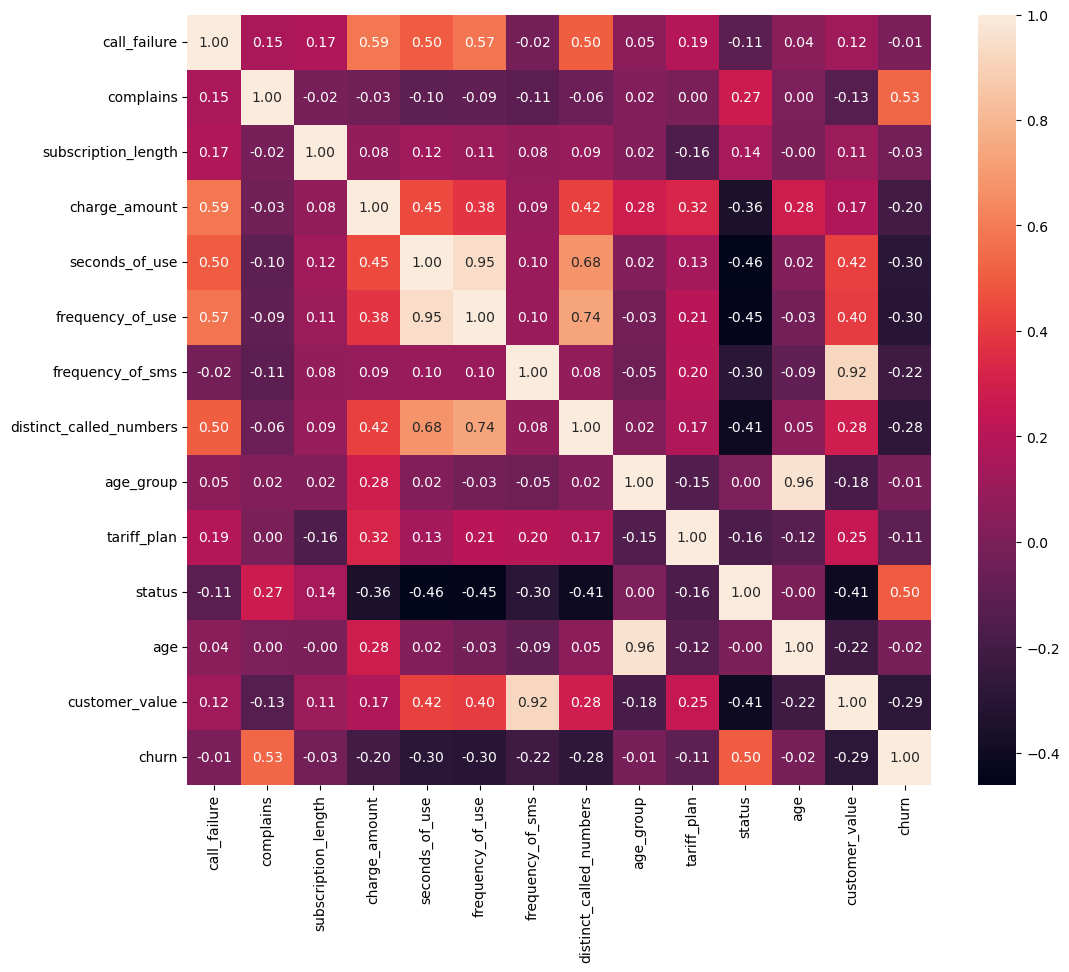

In [56]:
corr_table = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_table, annot=True, annot_kws={"size": 10}, fmt=".2f")
plt.show()

In [27]:
df.churn.value_counts()

churn
0    2655
1     495
Name: count, dtype: int64

In [28]:
df.churn.value_counts()[1] / (df.churn.value_counts()[0] + df.churn.value_counts()[1])

0.15714285714285714

In [29]:
def prepare_data(df):
    # Create feature matrix X and target vector y
    X = df.drop('churn', axis=1)
    y = df['churn']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    return X_train, X_test, y_train, y_test

In [30]:
def train_xgboost(X_train, X_test, y_train, y_test):
    # Initialize XGBoost classifier
    params = {
        'objective': 'binary:logistic',
        'max_depth': 4,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'min_child_weight': 1,
        'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),  # Handle class imbalance
        'eval_metric': 'auc'
    }
    
    # Convert data into DMatrix format
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    # Train model with early stopping
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=[(dtrain, 'train'), (dtest, 'test')],
        early_stopping_rounds=50,
        verbose_eval=100
    )
    
    return model, dtrain, dtest

In [31]:
def evaluate_model(model, dtest, y_test):
    # Make predictions
    y_pred_proba = model.predict(dtest)
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Calculate metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba)
    }
    
    return metrics, y_pred

In [32]:
def plot_feature_importance(model, feature_names):
    importance_dict = model.get_score(importance_type='gain')
    importance_df = pd.DataFrame(
        {'feature': importance_dict.keys(), 
         'importance': importance_dict.values()}
    )
    importance_df = importance_df.sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.bar(importance_df['feature'], importance_df['importance'])
    plt.xticks(rotation=45, ha='right')
    plt.title('Feature Importance (Gain)')
    plt.tight_layout()
    plt.show()

In [33]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Calculate additional metrics from confusion matrix
    tn, fp, fn, tp = cm.ravel()
    total = tn + fp + fn + tp
    
    print("\nDetailed Confusion Matrix Metrics:")
    print(f"True Negatives (Correctly predicted no churn): {tn} ({tn/total*100:.1f}%)")
    print(f"False Positives (Incorrectly predicted churn): {fp} ({fp/total*100:.1f}%)")
    print(f"False Negatives (Missed actual churns): {fn} ({fn/total*100:.1f}%)")
    print(f"True Positives (Correctly predicted churn): {tp} ({tp/total*100:.1f}%)")

[0]	train-auc:0.83244	test-auc:0.81811
[100]	train-auc:0.99558	test-auc:0.98850
[200]	train-auc:0.99891	test-auc:0.99174
[300]	train-auc:0.99960	test-auc:0.99317
[343]	train-auc:0.99966	test-auc:0.99285

Model Performance Metrics:
Accuracy: 0.9619
Precision: 0.8378
Recall: 0.9394
F1 Score: 0.8857
ROC AUC: 0.9928


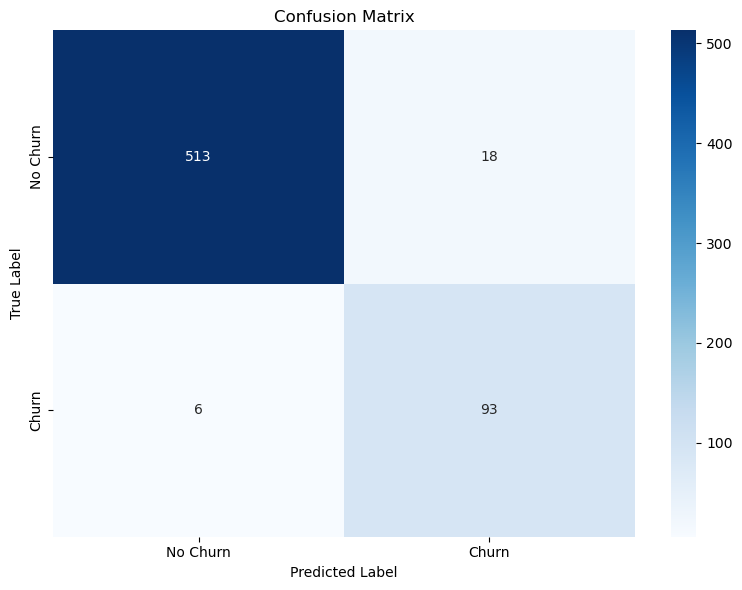


Detailed Confusion Matrix Metrics:
True Negatives (Correctly predicted no churn): 513 (81.4%)
False Positives (Incorrectly predicted churn): 18 (2.9%)
False Negatives (Missed actual churns): 6 (1.0%)
True Positives (Correctly predicted churn): 93 (14.8%)


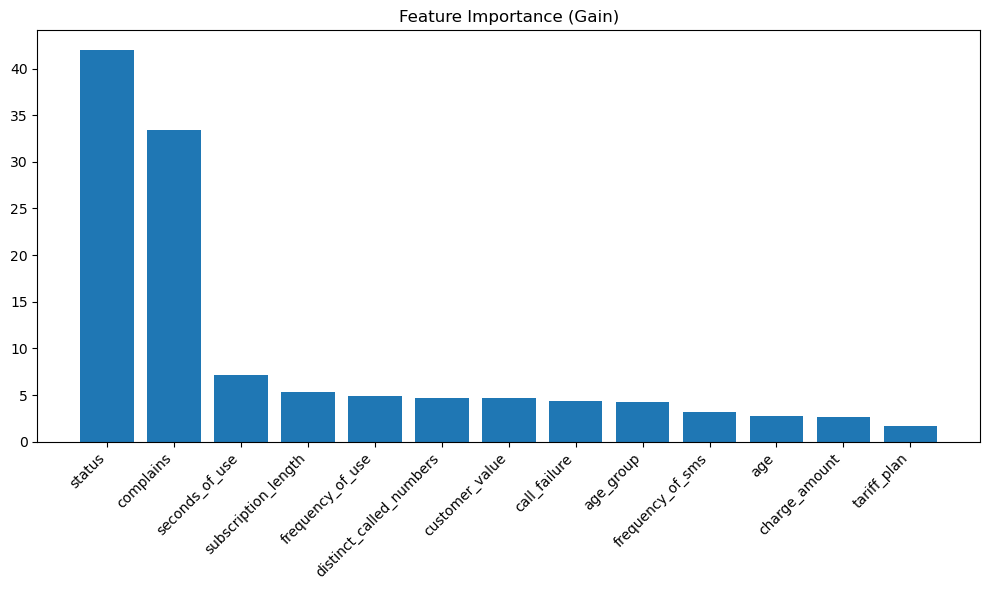

In [34]:
def main():
    # Prepare data
    X_train, X_test, y_train, y_test = prepare_data(df)
    
    # Train model
    model, dtrain, dtest = train_xgboost(X_train, X_test, y_train, y_test)
    
    # Evaluate model
    metrics, y_pred = evaluate_model(model, dtest, y_test)
    
    # Print general metrics
    print("\nModel Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred)
    
    # Plot feature importance
    plot_feature_importance(model, X_train.columns)
    
    return model

if __name__ == "__main__":
    model = main()